# A deeper look at the data pipeline

## Introduction

This notebook focuses on designing and implementing all neccessary functionality to have a dataset ready for use with a transformer based approach.

### Objectives
1. **Implement masking for our data loading pipeline:** (Done)
   - To make the transformer more efficient so that it doesn't attend to padded sequences we should provide a mask for it
   

2. **Validate the data pipeline and get a deep understanding of how it works:**
   - After we have implemented the masking we develop some validation code to check if the data is loaded correctly



# A closer look at the NASA Turbofan Degradation Dataset

In [1]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
from tqdm import tqdm
from ipydatagrid import DataGrid, TextRenderer

# Define paths
DATA_DIR = "./data/CMAPSSData"
TRAIN_FILE = "train_FD001.txt"
TEST_FILE = "test_FD001.txt"

# Column names based on dataset description
column_names = ['engine_id', 'cycle'] + \
               [f'os_{i+1}' for i in range(3)] + \
               [f'sensor_{i}' for i in range(1, 22)]

# Load data
def load_data(file_path, columns):
    return pd.read_csv(file_path, sep=r'\s+', header=None, names=columns)

train_data = load_data(os.path.join(DATA_DIR, TRAIN_FILE), column_names)

# Compute RUL
max_cycles = train_data.groupby('engine_id')['cycle'].max().reset_index()
max_cycles.columns = ['engine_id', 'max_cycle']
train_data = train_data.merge(max_cycles, on='engine_id')
train_data['RUL'] = train_data['max_cycle'] - train_data['cycle']
train_data = train_data.drop(columns=['max_cycle'])

# Feature engineering: Statistical features extraction
def extract_statistical_features(data, sensors):
    features = []
    grouped = data.groupby('engine_id')
    
    for engine_id, group in tqdm(grouped, desc="Extracting features"):
        # Ensure the data is sorted by cycle
        group = group.sort_values(by='cycle')
        
        # Compute statistical features
        stats = {
            'engine_id': engine_id,
            'min_cycle': group['cycle'].min(),
            'max_cycle': group['cycle'].max(),
            'mean_cycle': group['cycle'].mean(),
            'std_cycle': group['cycle'].std()
        }
        
        for sensor in sensors:
            sensor_values = group[sensor]
            stats[f'{sensor}_mean'] = sensor_values.mean()
            stats[f'{sensor}_std'] = sensor_values.std()
            stats[f'{sensor}_min'] = sensor_values.min()
            stats[f'{sensor}_max'] = sensor_values.max()
        
        features.append(stats)
    
    return pd.DataFrame(features)

# Select sensors for statistical analysis
sensor_columns = [f'sensor_{i}' for i in range(1, 22)]

# Extract features
statistical_features = extract_statistical_features(train_data, sensor_columns)

# Save features to a CSV file for reuse
statistical_features.to_csv("statistical_features_train.csv", index=False)

# Load the CSV
features = pd.read_csv("statistical_features_train.csv")

# Set specific widths for some columns, let others autosize
header_renderer = TextRenderer(background_color="lightgray", text_wrap=True)

grid = DataGrid(
    features, 
    layout={'height': '400px'}, 
    column_options={"header_renderer": header_renderer},
)
grid

Extracting features: 100%|███████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 575.52it/s]


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

Let's find out how many engines and sequences are in the train dataset:

In [2]:
# Number of engines in the dataset
num_engines = train_data['engine_id'].nunique()
print(f"Number of engines: {num_engines}")

# Longest and shortest sequence length of an engine
engine_sequence_lengths = train_data.groupby('engine_id')['cycle'].count()
longest_sequence = engine_sequence_lengths.max()
shortest_sequence = engine_sequence_lengths.min()

print(f"Longest sequence length: {longest_sequence} cycles")
print(f"Shortest sequence length: {shortest_sequence} cycles")

Number of engines: 100
Longest sequence length: 362 cycles
Shortest sequence length: 128 cycles


# Preparing our existing CMAPSSDataset for a transformer based network
Our sequence based CMAPSSDataset is already in good shape to serve as a data pipeline for the transformer net architecture. But we need to add one thing:

1. Creating an attention mask to ignore padded timesteps

# Test the tabular dataset implementation

In [3]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from codebase.v5.dataset import CMAPSSDataset
from torch.utils.data import DataLoader

constant_cols = train_data[column_names].nunique()
constant_cols = constant_cols[constant_cols == 1]

data_dir = "data/CMAPSSData"
feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

drop_constant_columns = True
compute_engineered_features = False

if drop_constant_columns:
    feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

# Create datasets with transforms
train_dataset = CMAPSSDataset(
    data_dir=data_dir, data_index=1, mode="train", 
    transform=None, 
    feature_cols=feature_cols,
    compute_engineered_features=compute_engineered_features)

test_dataset = CMAPSSDataset(
    data_dir=data_dir, data_index=1, mode="test", 
    transform=None, 
    feature_cols=feature_cols, scaler=train_dataset.scaler,
    compute_engineered_features=compute_engineered_features)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4) # do not shuffle here, the data is temporal
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4) # do not shuffle here, the data is temporal

print("Training dataset with transforms:")
for features, targets in train_loader:
    print("Features:", features.shape)
    print("Targets:", targets.shape)
    break

print("\nTest dataset with transforms:")
for features in test_loader:
    print("Features:", features.shape)
    break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Training dataset with transforms:
Features: torch.Size([32, 17])
Targets: torch.Size([32])

Test dataset with transforms:
Features: torch.Size([32, 17])


# Test the sequence dataset implementation

In [4]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from codebase.v5.dataset import CMAPSSDataset, SequenceCMAPSSDataset

def prepare_sequence_dataloader(
        data_dir, data_index, feature_cols, batch_size=32, 
        mode="train", compute_engineered_features=True, sequence_length=30, overlap=0, scaler=None):
    """
    Prepares the DataLoader for the CMAPSS dataset.
    
    Args:
        data_dir (str): Directory containing the dataset files.
        data_index (int): Index of the dataset file to load (0 to 3).
        feature_cols (list): List of feature columns to use.
        batch_size (int): Batch size for the DataLoader.
        mode (str): Mode of the dataset, "train" or "test".
        compute_engineered_features (bool): Whether to include engineered features.
        sequence_length (int): Length of the sequence to extract.
        overlap (int): Number of overlapping time steps between consecutive sequences.
        
    Returns:
        DataLoader: PyTorch DataLoader for the CMAPSS dataset with masking.
    """
    # Initialize the base dataset
    tabular_dataset = CMAPSSDataset(
        data_dir=data_dir,
        data_index=data_index,
        feature_cols=feature_cols,
        mode=mode,
        compute_engineered_features=compute_engineered_features,
        features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"],
        scaler=scaler if mode == "test" else None
    )
    
    # Wrap it with the sequence-based dataset
    sequence_dataset = SequenceCMAPSSDataset(
        dataset=tabular_dataset, sequence_length=sequence_length, overlap=overlap)
    
    # Create DataLoader with the custom collate function
    dataloader = DataLoader(
        sequence_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    
    return dataloader, tabular_dataset, sequence_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def test_sequence_dataset(dataloader, mode="train"):
    """
    Test the SequenceCMAPSSDataset and display an example output.

    Args:
        dataset (CMAPSSDataset): The original CMAPSSDataset instance.
        sequence_length (int): Length of each sequence.
        batch_size (int): Batch size for the DataLoader.
    """
    
    # Fetch one batch
    for batch_idx, batch in enumerate(dataloader):
        if mode == "train":
            sequences, targets, engine_ids, cycles = batch
            print(f"Batch {batch_idx + 1}")
            print(f"Sequences Shape: {sequences.shape}")  # Expected: (batch_size, sequence_length, num_features)
            print(f"Targets Shape: {targets.shape}")  # Expected: (batch_size,)
            print(f"Engine Ids Shape: {engine_ids.shape}")
            print(f"Cycles Shape: {cycles.shape}")
            print()            
            print(f"Sample Sequence (First in Batch):\n{sequences[0]}")
            print(f"Corresponding Target (First in Batch):\n{targets[0]}")
            print(f"Engine ID (First in batch): {engine_ids[0]}")
            print(f"Cycles (First in batch): {cycles[0]}")
        else:
            sequences, engine_ids, cycles = batch
            print(f"Batch {batch_idx + 1}")
            print(f"Sequences Shape: {sequences.shape}")  # Expected: (batch_size, sequence_length, num_features)   
            print(f"Engine Ids Shape: {engine_ids.shape}")
            print(f"Cycles Shape: {cycles.shape}")
            print()
            print(f"Sample Sequence (First in Batch):\n{sequences[0]}")
            print(f"Engine ID (First in batch): {engine_ids[0]}")
            print(f"Cycles (First in batch): {cycles[0]}")
        break  # Only fetch the first batch for demonstration


In [6]:
import pandas as pd

# Set up paths and features
data_dir = "data/CMAPSSData"
data_index = 1  # Choose FD001, FD002, etc.

compute_engineered_features = False
sequence_length = 10
batch_size = 256
overlap = 0

train_data = pd.read_csv("./data/CMAPSSData/train_FD001.txt", sep=r'\s+', header=None)
train_data.columns = ['engine_id', 'cycle'] + [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

feature_cols = [f'os_{i+1}' for i in range(3)] + [f'sensor_{i}' for i in range(1, 22)]

constant_cols = train_data[feature_cols].nunique()
constant_cols = constant_cols[constant_cols == 1]

feature_cols = [col for col in feature_cols if col not in constant_cols.index.tolist()]

# Prepare DataLoader
train_loader, tabular_dataset_train, sequence_train = prepare_sequence_dataloader(
    data_dir=data_dir, data_index=data_index, feature_cols=feature_cols, 
    batch_size=batch_size, mode="train", sequence_length=sequence_length, overlap=overlap,
    compute_engineered_features=compute_engineered_features)

# Test the sequence dataset
test_sequence_dataset(train_loader, mode="train")

test_loader, tabular_dataset_test, sequence_test = prepare_sequence_dataloader(
    data_dir=data_dir, data_index=data_index, feature_cols=feature_cols, 
    batch_size=batch_size, mode="test", sequence_length=sequence_length, overlap=overlap,
    compute_engineered_features=compute_engineered_features, 
    scaler=tabular_dataset_train.scaler
)

# Test the sequence dataset
test_sequence_dataset(test_loader, mode="test")

Batch 1
Sequences Shape: torch.Size([256, 10, 17])
Targets Shape: torch.Size([256])
Engine Ids Shape: torch.Size([256])
Cycles Shape: torch.Size([256, 10])

Sample Sequence (First in Batch):
tensor([[-0.3160, -1.3730, -1.7217, -0.1343, -0.9259,  0.1417,  1.1211, -0.5163,
         -0.8628, -0.2665,  0.3343, -1.0589, -0.2691, -0.6038, -0.7817,  1.3485,
          1.1944],
        [ 0.8727, -1.0317, -1.0618,  0.2115, -0.6437,  0.1417,  0.4319, -0.7981,
         -0.9588, -0.1916,  1.1749, -0.3636, -0.6428, -0.2759, -0.7817,  1.0165,
          1.2369],
        [-1.9619,  1.0157, -0.6618, -0.4132, -0.5260,  0.1417,  1.0082, -0.2346,
         -0.5571, -1.0153,  1.3647, -0.9198, -0.5516, -0.6491, -2.0731,  0.7399,
          0.5034],
        [ 0.3241, -0.0080, -0.6618, -1.2613, -0.7848,  0.1417,  1.2228,  0.1880,
         -0.7138, -1.5395,  1.9613, -0.2246, -0.5202, -1.9717, -0.7817,  0.3526,
          0.7778],
        [-0.8646, -0.6905, -0.6218, -1.2515, -0.3015,  0.1417,  0.7144, -0.5163,
    

# Validate the sequence loader

In [7]:
import torch

def test_sequence_dataset(tabular_dataset, sequence_dataset):
    # Initialize results
    sequence_length = sequence_dataset.sequence_length
    overlap = sequence_dataset.overlap
    feature_cols = tabular_dataset.feature_cols
    errors = []

    print("Validating SequenceCMAPSSDataset...")

    # Loop through all sequences in SequenceCMAPSSDataset
    for idx, item in enumerate(sequence_dataset):
        if tabular_dataset.mode == "train":
            seq_features, seq_rul, engine_id, seq_cycles = item
        else:
            seq_features, engine_id, seq_cycles = item

        # Get the start and end indices from sequence_dataset's indices
        engine_id_idx, start_idx, end_idx = sequence_dataset.indices[idx]

        # Extract corresponding rows from the tabular dataset
        tabular_data = tabular_dataset.data[tabular_dataset.data['engine_id'] == engine_id]
        tabular_data = tabular_data.iloc[start_idx:end_idx]

        # Verify sequence length (allow for padding)
        if seq_features.shape[0] != sequence_length:
            errors.append(f"Sequence {idx}: Incorrect sequence length ({seq_features.shape[0]} != {sequence_length})")
            continue

        # Verify features (ignoring padding rows)
        for i, (tabular_row, seq_feature_row) in enumerate(zip(tabular_data[feature_cols].values, seq_features[:len(tabular_data)])):
            if not torch.allclose(torch.tensor(tabular_row, dtype=torch.float32), seq_feature_row, atol=1e-6):
                errors.append(f"Sequence {idx}, Row {i}: Features do not match")
                break

        # Verify RUL (only for train mode)
        if tabular_dataset.mode == "train" and seq_rul is not None:
            expected_rul = tabular_data['RUL'].iloc[-1]
            if not torch.isclose(seq_rul, torch.tensor(expected_rul, dtype=torch.float32), atol=1e-6):
                errors.append(f"Sequence {idx}: RUL mismatch ({seq_rul.item()} != {expected_rul})")

    # Print validation results
    if errors:
        print(f"Validation failed with {len(errors)} errors:")
        for error in errors[:10]:  # Show up to 10 errors
            print(error)
        if len(errors) > 10:
            print(f"...and {len(errors) - 10} more errors.")
    else:
        print("All sequences validated successfully!")

# Assuming tabular_dataset and sequence_dataset are initialized
print("Training dataset validation:")
test_sequence_dataset(tabular_dataset_train, sequence_train)

print("\nTest dataset validation:")
test_sequence_dataset(tabular_dataset_test, sequence_test)

Training dataset validation:
Validating SequenceCMAPSSDataset...
All sequences validated successfully!

Test dataset validation:
Validating SequenceCMAPSSDataset...
All sequences validated successfully!


In [7]:
from IPython.display import HTML, display
import pandas as pd

def display_engine_sequences(sequence_dataset, engine_id):
    """
    Extract and display all sequences for a specific engine ID with enhanced visualization.

    Args:
        sequence_dataset (SequenceCMAPSSDataset): The sequence dataset.
        engine_id (int): The engine ID to extract sequences for.
    """
    # Collect all sequences for the specified engine ID
    engine_sequences = [
        (idx, sequence_dataset[idx]) for idx, (eid, _, _) in enumerate(sequence_dataset.indices) if eid == engine_id
    ]

    if not engine_sequences:
        print(f"No sequences found for engine ID {engine_id}.")
        return

    print(f"Found {len(engine_sequences)} sequences for engine ID {engine_id}.")

    # Prepare data for display
    sequence_data = []
    for seq_idx, item in engine_sequences:
        if sequence_dataset.dataset.mode == "train":
            seq_features, seq_rul, eid, seq_cycles = item
            sequence_data.append({
                "Sequence Index": seq_idx,
                "Cycles": seq_cycles.tolist(),
                "Features": seq_features.numpy().tolist(),
                "RUL": seq_rul.item(),
            })
        else:
            seq_features, eid, seq_cycles = item
            sequence_data.append({
                "Sequence Index": seq_idx,
                "Cycles": seq_cycles.tolist(),
                "Features": seq_features.numpy().tolist(),
            })

    # Convert to DataFrame for better visualization
    sequence_df = pd.DataFrame(sequence_data)

    # Enhance display with custom CSS for full width and tooltips
    html = sequence_df.to_html(
        escape=False,  # Disable escaping to allow tooltips
        index=False,  # Do not show DataFrame index
        justify="left",  # Align columns to the left
    )

    # CSS and JavaScript for tooltip
    tooltip_script = """
    <style>
        .dataframe {
            width: 100% !important;  /* Use full width */
            table-layout: fixed;  /* Fixed table layout */
        }
        .dataframe td {
            text-overflow: ellipsis;  /* Show ellipsis for long text */
            overflow: hidden;
            white-space: nowrap;
        }
        .dataframe td:hover {
            overflow: visible;
            white-space: normal;
            position: relative;
            z-index: 1;
        }
    </style>
    """
    
    # Display the DataFrame with tooltips
    display(HTML(tooltip_script + html))


# Usage Example
# Specify the engine ID you want to extract sequences for
engine_id_to_display = 1

# Call the function for train or test dataset
display_engine_sequences(sequence_train, engine_id_to_display)

Found 20 sequences for engine ID 1.


Sequence Index,Cycles,Features,RUL
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[[-0.3159796893596649, -1.372953176498413, -1.721725344657898, -0.13425517082214355, -0.9259359836578369, 0.14168332517147064, 1.1211405992507935, -0.5163384079933167, -0.8628132939338684, -0.26646658778190613, 0.33426183462142944, -1.0588902235031128, -0.2690710425376892, -0.6038156747817993, -0.7817097902297974, 1.3484927415847778, 1.1944270133972168], [0.8727219104766846, -1.0317203998565674, -1.0617797374725342, 0.2115284949541092, -0.6437258720397949, 0.14168332517147064, 0.43193018436431885, -0.7980930209159851, -0.9588176012039185, -0.19158291816711426, 1.1748993396759033, -0.363646000623703, -0.6428447365760803, -0.2758518159389496, -0.7817097902297974, 1.0165278911590576, 1.2369219064712524], [-1.96187424659729, 1.015676736831665, -0.6618126034736633, -0.4131655991077423, -0.5259531736373901, 0.14168332517147064, 1.0081552267074585, -0.2345838099718094, -0.5571392774581909, -1.0153032541275024, 1.3647207021713257, -0.9198414087295532, -0.5516293048858643, -0.6491440534591675, -2.073094129562378, 0.7398905754089355, 0.5034227967262268], [0.3240904211997986, -0.008021808229386806, -0.6618126034736633, -1.2613141536712646, -0.7848309278488159, 0.14168332517147064, 1.2228273153305054, 0.1880480796098709, -0.713825523853302, -1.5394890308380127, 1.9613021612167358, -0.22459715604782104, -0.5201756954193115, -1.9716651439666748, -0.7817097902297974, 0.35259830951690674, 0.7777921557426453], [-0.8646112084388733, -0.6904875040054321, -0.6218159198760986, -1.2515279054641724, -0.30151835083961487, 0.14168332517147064, 0.7143934369087219, -0.5163384079933167, -0.4570592939853668, -0.9778614640235901, 1.0528713464736938, -0.7807925343513489, -0.5217483639717102, -0.3398447632789612, -0.1360175609588623, 0.4632532298564911, 1.0595518350601196], [-1.96187424659729, -0.34925466775894165, -1.161771535873413, -0.9872969388961792, -1.1737030744552612, 0.14168332517147064, 1.4713950157165527, -1.0798475742340088, -0.7047684788703918, -1.4271634817123413, 0.3613791763782501, -0.9198414087295532, -0.5715498924255371, -0.8357901573181152, -1.4274020195007324, 0.9058730006217957, 0.7131259441375732], [0.4612483084201813, 0.3332110345363617, -0.40183401107788086, 0.29308125376701355, -1.2403669357299805, 0.14168332517147064, 1.0985435247421265, -1.0798475742340088, -0.27682480216026306, -0.6783267855644226, 1.2291339635849, -0.9198414087295532, -0.5993339419364929, -1.1930841207504272, -0.7817097902297974, 1.5698026418685913, 0.8101252317428589], [-1.5504006147384644, 1.015676736831665, -0.2418471872806549, -1.233586311340332, -0.8848266005516052, 0.14168332517147064, 0.544915497303009, -1.3616021871566772, -1.1068997383117676, -1.1276288032531738, 1.4325140714645386, -0.9198414087295532, -0.6648622751235962, -0.9211140871047974, -1.4274020195007324, 0.8505455255508423, 0.19302518665790558], [0.36980971693992615, 0.3332110345363617, -1.1217747926712036, 0.07451987266540527, -1.5703526735305786, 0.14168332517147064, 0.36413899064064026, -0.6572157144546509, -0.8505863547325134, -0.940419614315033, 0.5105245113372803, -0.6417437195777893, -0.9468962550163269, -1.8490118980407715, -0.7817097902297974, 1.2931653261184692, 1.0798755884170532], [-1.5046812295913696, 0.3332110345363617, -1.9417072534561157, 0.11692730337381363, -0.9414908289909363, 0.14168332517147064, 0.2511536777019501, -0.6572157144546509, -0.6132926940917969, -1.9139072895050049, 0.5105245113372803, -0.502694845199585, -0.7534565925598145, -0.3611757457256317, -0.1360175609588623, 0.7398905754089355, 1.6600234508514404]]",182.0
1,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]","[[0.8270026445388794, -1.0317203998565674, -0.8018010854721069, -1.4309439659118652, -0.9214916825294495, 0.14168332517147064, 1.3245141506195068, -0.6572157144546509, -0.7079384326934814, -1.4646053314208984, -0.0182635560631752, -1.1979390382766724, -0.16632258892059326, -0.21719160676002502, -0.7817097902297974, 0.6845631003379822, 1

Test the padding of the sequences:

In [27]:
def test_sequence_padding(sequence_dataset):
    """
    Test to verify padding correctness in SequenceCMAPSSDataset.

    Args:
        sequence_dataset (SequenceCMAPSSDataset): The sequence dataset to validate.
    """
    sequence_length = sequence_dataset.sequence_length
    feature_cols = sequence_dataset.feature_cols
    errors = []

    print("Validating sequence padding correctness...")

    for idx, item in enumerate(sequence_dataset):
        if sequence_dataset.dataset.mode == "train":
            seq_features, _, engine_id, _ = item
        else:
            seq_features, engine_id, _ = item

        # Check sequence length
        if seq_features.shape[0] != sequence_length:
            errors.append(f"Sequence {idx}: Incorrect sequence length ({seq_features.shape[0]} != {sequence_length})")
            continue

        # Fetch the original data for the engine and indices
        _, start_idx, end_idx = sequence_dataset.indices[idx]
        engine_data = sequence_dataset.dataset.data[
            sequence_dataset.dataset.data['engine_id'] == engine_id
        ].iloc[start_idx:end_idx]

        # Check the unpadded portion of the sequence
        unpadded_length = len(engine_data)
        unpadded_features = seq_features[:unpadded_length].numpy()
        original_features = engine_data[feature_cols].values

        if not torch.allclose(torch.tensor(original_features, dtype=torch.float32), torch.tensor(unpadded_features), atol=1e-6):
            errors.append(f"Sequence {idx}: Unpadded features do not match the original data.")

        # Check the padded portion of the sequence (if any)
        if unpadded_length < sequence_length:
            padded_features = seq_features[unpadded_length:]
            if not torch.allclose(padded_features, torch.zeros_like(padded_features)):
                errors.append(f"Sequence {idx}: Padded portion is not zero-filled.")

    # Print validation results
    if errors:
        print(f"Padding validation failed with {len(errors)} errors:")
        for error in errors[:10]:  # Show up to 10 errors
            print(error)
        if len(errors) > 10:
            print(f"...and {len(errors) - 10} more errors.")
    else:
        print("All sequences are correctly padded!")


# Usage Example
# Assuming `sequence_dataset` is an initialized SequenceCMAPSSDataset instance
test_sequence_padding(sequence_train)

Validating sequence padding correctness...
All sequences are correctly padded!


In [28]:
def print_padded_sequence(sequence_dataset, engine_id=None):
    """
    Print one padded sequence (usually the last sequence of an engine).

    Args:
        sequence_dataset (SequenceCMAPSSDataset): The sequence dataset.
        engine_id (int, optional): Specific engine ID to inspect. If None, the last engine is selected.
    """
    # Determine the engine to inspect
    if engine_id is None:
        engine_id = sequence_dataset.dataset.data['engine_id'].iloc[-1]

    # Find all sequence indices for the specified engine
    engine_sequences = [
        idx for idx, (eid, _, _) in enumerate(sequence_dataset.indices)
        if eid == engine_id
    ]

    if not engine_sequences:
        print(f"No sequences found for engine ID {engine_id}.")
        return

    # Select the last sequence for the engine
    last_sequence_idx = engine_sequences[-1]
    item = sequence_dataset[last_sequence_idx]

    # Unpack the sequence
    if sequence_dataset.dataset.mode == "train":
        seq_features, seq_rul, eid, seq_cycles = item
    else:
        seq_features, eid, seq_cycles = item

    print(f"Engine ID: {eid}")
    print(f"Sequence Index: {last_sequence_idx}")
    print(f"Sequence Cycles: {seq_cycles.tolist()}")
    print(f"Sequence Features (Shape: {seq_features.shape}):")
    print(seq_features.numpy())

    if sequence_dataset.dataset.mode == "train":
        print(f"RUL for last cycle in the sequence: {seq_rul.item()}")

# Optionally, specify a specific engine ID
print_padded_sequence(sequence_train, engine_id=1)

Engine ID: 1
Sequence Index: 19
Sequence Cycles: [191, 192, 0, 0, 0, 0, 0, 0, 0, 0]
Sequence Features (Shape: torch.Size([10, 17])):
[[ 0.00405537 -1.3729532   1.3180244   1.9306605   1.8706106   0.14168333
  -2.7655542   2.582962   -1.018141    2.2795782  -2.4995      2.8344774
  -1.5277395   2.0065637   0.50967467 -2.0264828  -1.4799811 ]
 [ 0.415529   -0.00802181  1.7179915   1.7757102   2.0294926   0.14168333
  -2.3927026   3.1464713  -1.4501604   2.6539965  -1.8080078   3.1125753
  -1.720655    1.8439147   1.8010591  -1.8605005  -3.0005598 ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.    

## The code for the grouped k-fold approach:
See explanations in previous notebook.

In [29]:
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader

# Function to implement Group k-Fold with your custom dataset
def prepare_kfold_cross_validation_loaders(original_dataset, sequence_length, overlap, n_splits=5, batch_size=32):
    """
    Implements Group k-Fold Cross-Validation for the CMAPSS dataset.
    
    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        sequence_length (int): Length of each sequence.
        overlap (int): Overlap between sequences.
        n_splits (int): Number of folds for cross-validation.
        batch_size (int): Batch size for the DataLoader.
    
    Returns:
        List[Tuple[DataLoader, DataLoader]]: Training and validation DataLoaders for each fold.
    """

    # Define a custom collate function for masking the sequences
    def collate_fn(batch, mode="train"):
        """
        Custom collate function to handle padding and masking.
        
        Args:
            batch (list): List of tuples:
                - Train mode: (features, target, engine_id, cycles)
                - Test mode:  (features, engine_id, cycles)
            mode (str): "train" or "test"
            
        Returns:
            tuple:
                If mode="train": (features_tensor, targets_tensor, masks_tensor, engine_ids, cycles_tensor)
                If mode="test":  (features_tensor, masks_tensor, engine_ids, cycles_tensor)
        """
        features_list = []
        targets_list = []
        masks_list = []
        engine_ids = []
        cycles_list = []
        
        for sample in batch:
            # 1) Handle difference between train & test samples
            if mode == "train":
                features, target, engine_id, cycles = sample
            else:
                features, engine_id, cycles = sample
                target = None  # No target in test mode
            
            # 2) Build a mask to distinguish padded vs. non-padded timesteps
            #    (assuming padded rows are all zeros)
            mask = (features.sum(dim=-1) == 0)  # True for padded positions, False for valid ones
            
            # 3) Skip fully-padded sequences: mask.sum() == len(mask)
            #    means no real timesteps (all zeros).
            if mask.sum() == mask.size(0):  # mask.size(0) is the sequence length
                print("This should not occur: Skipping fully-padded sequence.")
                continue
            
            # Otherwise, keep this sample
            features_list.append(features)
            masks_list.append(mask)
            engine_ids.append(engine_id)
            cycles_list.append(cycles)

            # Only append target in train mode
            if mode == "train":
                targets_list.append(target)

        # 4) Stack features and masks
        features_tensor = torch.stack(features_list)  # (batch_size, seq_len, num_features)
        masks_tensor = torch.stack(masks_list)        # (batch_size, seq_len)
        cycles_tensor = torch.stack(cycles_list)      # (batch_size, seq_len)

        # 5) Return depends on mode
        if mode == "train":
            targets_tensor = torch.stack(targets_list)  # (batch_size,)
            return features_tensor, targets_tensor, masks_tensor, engine_ids, cycles_tensor
        else:
            return features_tensor, masks_tensor, engine_ids, cycles_tensor

    # Extract engine IDs and features for grouping
    engine_ids = original_dataset.data['engine_id'].values
    features = original_dataset.data[original_dataset.feature_cols].values
    targets = original_dataset.data['RUL'].values

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=n_splits)

    fold_loaders = []  # Store DataLoaders for each fold

    # Perform Group k-Fold split (features and targets are not directly used for the split)
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(features, targets, groups=engine_ids)):
        print(f"Fold {fold + 1}/{n_splits}")
        
        # Create train and validation datasets
        train_data = original_dataset.data.iloc[train_idx]
        val_data = original_dataset.data.iloc[val_idx]

        train_dataset = SequenceCMAPSSDataset(
            dataset=CMAPSSDatasetSubset(train_data, original_dataset.feature_cols, mode="train"),
            sequence_length=sequence_length,
            overlap=overlap
        )

        val_dataset = SequenceCMAPSSDataset(
            dataset=CMAPSSDatasetSubset(val_data, original_dataset.feature_cols, mode="train"),
            sequence_length=sequence_length,
            overlap=overlap
        )

        # Create DataLoaders
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=False, num_workers=8, collate_fn=lambda batch: collate_fn(batch, mode="train"))
        
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, collate_fn=lambda batch: collate_fn(batch, mode="train"))

        fold_loaders.append((train_loader, val_loader))
    
    return fold_loaders

# Helper class to create a subset of the CMAPSSDataset
class CMAPSSDatasetSubset(CMAPSSDataset):
    def __init__(self, data_subset, feature_cols, mode):
        """
        Creates a subset of the CMAPSSDataset using the provided data.

        Args:
            data_subset (pd.DataFrame): Subset of the original dataset.
            feature_cols (list): List of feature columns to include.
            mode (str): Mode of the dataset, "train" or "test".
        """
        self.data = data_subset
        self.feature_cols = feature_cols
        self.mode = mode


In [30]:
# Initialize the dataset
dataset = CMAPSSDataset(
    data_dir=data_dir,
    data_index=data_index,
    feature_cols=feature_cols,
    mode="train",
    compute_engineered_features=compute_engineered_features,
    features_to_engineer=["sensor_12", "sensor_7", "sensor_21", "sensor_20", "sensor_11", "sensor_4", "sensor_15"]
)

# Perform Group k-Fold Cross-Validation
sequence_length = sequence_length
overlap = 0 # see explanation below
n_splits = 5
batch_size = batch_size

# 2. Perform Group k-Fold Cross-Validation
fold_loaders = prepare_kfold_cross_validation_loaders(
    original_dataset=dataset,
    sequence_length=sequence_length,
    overlap=overlap,
    n_splits=n_splits,
    batch_size=batch_size
)

# Access the DataLoaders for each fold
for fold, (train_loader, val_loader) in enumerate(fold_loaders):
    print(f"Fold {fold + 1}")
    
    # Training DataLoader
    print(f"  Number of training sequences: {len(train_loader.dataset)}")
    first_train_item = next(iter(train_loader))
    train_features, train_targets, train_masks, train_engine_ids, cycles = first_train_item
    print(f"  Training Features Shape: {train_features.shape}")
    print(f"  Training Targets Shape: {train_targets.shape}")
    print(f"  Training Masks Shape: {train_masks.shape}")
    print(f"  First Training Item (Features):\n{train_features[0]}")
    print(f"  First Training Item (Target): {train_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")
    
    # Validation DataLoader
    print(f"  Number of validation sequences: {len(val_loader.dataset)}")
    first_val_item = next(iter(val_loader))
    val_features, val_targets, val_masks, train_engine_ids, cycles = first_val_item
    print(f"  Validation Features Shape: {val_features.shape}")
    print(f"  Validation Targets Shape: {val_targets.shape}")
    print(f"  Validation Masks Shape: {val_masks.shape}")
    print(f"  First Validation Item (Features):\n{val_features[0]}")
    print(f"  First Validation Item (Target): {val_targets[0]}")
    print(f"  Engine ID (First in batch): {train_engine_ids[0]}")
    print(f"  Cycles (For first sequence in batch): {cycles[0]}")

    break  # Only display the first fold for demonstration


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Fold 1
  Number of training sequences: 1686
  Training Features Shape: torch.Size([256, 10, 17])
  Training Targets Shape: torch.Size([256])
  Training Masks Shape: torch.Size([256, 10])
  First Training Item (Features):
tensor([[-0.8189,  2.0394, -1.5817, -1.0901, -1.9614, -7.0580,  1.3132, -1.2207,
         -0.4765, -2.2883,  1.2427, -0.5027, -0.3163, -1.3771, -1.4274,  0.6846,
          1.5593],
        [ 1.9700, -1.0317, -1.7217, -0.5665, -1.7559,  0.1417,  1.5844, -1.6434,
         -0.6310, -1.1276,  1.7444, -1.6151, -0.6638, -0.6785, -0.7817,  1.3485,
          1.0974],
        [ 0.8270,  1.0157, -2.2617, -0.3593, -1.1082, -7.0580,  2.0024, -0.7981,
         -0.4983, -1.2025,  1.5817, -1.4760, -0.1663, -1.6517, -1.4274,  1.6251,
          1.2499],
        [ 1.6042, -1.3730, -2.0017, -1.0395, -1.4281,  0.1417,  0.9969, -1.6434,
         -0.3275, -1.6518,  1.4596, -2.3103, -0.1737, -1.0758, -1.4274,  1.7358,
          1.9676],
        [ 

# Let's visualise some data of a fully prepared data loader

In [31]:
from IPython.display import HTML, display
import pandas as pd

def display_engine_sequences_from_loader(data_loader, engine_id, mode="train"):
    """
    Extract and display all sequences for a specific engine ID using a DataLoader.

    Args:
        data_loader (DataLoader): DataLoader to iterate over the dataset.
        engine_id (int): The engine ID to extract sequences for.
        mode (str): "train" or "test", determines whether RUL is included.
    """
    sequence_data = []

    # Iterate over the DataLoader to collect sequences for the specific engine ID
    for batch in data_loader:
        if mode == "train":
            features, targets, masks, engine_ids, cycles = batch
        else:
            features, masks, engine_ids, cycles = batch
            targets = None

        # Filter the sequences for the specified engine ID
        for i in range(len(engine_ids)):
            if engine_ids[i] == engine_id:
                sequence_info = {
                    "Features": features[i].numpy().tolist(),
                    "Masks": masks[i].numpy().tolist(),
                    "Cycles": cycles[i].numpy().tolist(),
                }
                if mode == "train":
                    sequence_info["RUL"] = targets[i].item()
                sequence_data.append(sequence_info)

    if not sequence_data:
        print(f"No sequences found for engine ID {engine_id}.")
        return

    print(f"Found {len(sequence_data)} sequences for engine ID {engine_id}.")

    # Convert to DataFrame for better visualization
    sequence_df = pd.DataFrame(sequence_data)

    # Enhance display with custom CSS for full width and tooltips
    html = sequence_df.to_html(
        escape=False,  # Disable escaping to allow tooltips
        index=False,  # Do not show DataFrame index
        justify="left",  # Align columns to the left
    )

    # CSS and JavaScript for tooltip
    tooltip_script = """
    <style>
        .dataframe {
            width: 100% !important;  /* Use full width */
            table-layout: fixed;  /* Fixed table layout */
        }
        .dataframe td {
            text-overflow: ellipsis;  /* Show ellipsis for long text */
            overflow: hidden;
            white-space: nowrap;
        }
        .dataframe td:hover {
            overflow: visible;
            white-space: normal;
            position: relative;
            z-index: 1;
        }
    </style>
    """
    
    # Display the DataFrame with tooltips
    display(HTML(tooltip_script + html))

# Display sequences for a specific engine ID
engine_id_to_display = 1

for fold, (train_loader, val_loader) in enumerate(fold_loaders):
    display_engine_sequences_from_loader(train_loader, engine_id_to_display, mode="train")

No sequences found for engine ID 1.
Found 20 sequences for engine ID 1.


Features,Masks,Cycles,RUL
"[[-0.3159796893596649, -1.372953176498413, -1.721725344657898, -0.13425517082214355, -0.9259359836578369, 0.14168332517147064, 1.1211405992507935, -0.5163384079933167, -0.8628132939338684, -0.26646658778190613, 0.33426183462142944, -1.0588902235031128, -0.2690710425376892, -0.6038156747817993, -0.7817097902297974, 1.3484927415847778, 1.1944270133972168], [0.8727219104766846, -1.0317203998565674, -1.0617797374725342, 0.2115284949541092, -0.6437258720397949, 0.14168332517147064, 0.43193018436431885, -0.7980930209159851, -0.9588176012039185, -0.19158291816711426, 1.1748993396759033, -0.363646000623703, -0.6428447365760803, -0.2758518159389496, -0.7817097902297974, 1.0165278911590576, 1.2369219064712524], [-1.96187424659729, 1.015676736831665, -0.6618126034736633, -0.4131655991077423, -0.5259531736373901, 0.14168332517147064, 1.0081552267074585, -0.2345838099718094, -0.5571392774581909, -1.0153032541275024, 1.3647207021713257, -0.9198414087295532, -0.5516293048858643, -0.6491440534591675, -2.073094129562378, 0.7398905754089355, 0.5034227967262268], [0.3240904211997986, -0.008021808229386806, -0.6618126034736633, -1.2613141536712646, -0.7848309278488159, 0.14168332517147064, 1.2228273153305054, 0.1880480796098709, -0.713825523853302, -1.5394890308380127, 1.9613021612167358, -0.22459715604782104, -0.5201756954193115, -1.9716651439666748, -0.7817097902297974, 0.35259830951690674, 0.7777921557426453], [-0.8646112084388733, -0.6904875040054321, -0.6218159198760986, -1.2515279054641724, -0.30151835083961487, 0.14168332517147064, 0.7143934369087219, -0.5163384079933167, -0.4570592939853668, -0.9778614640235901, 1.0528713464736938, -0.7807925343513489, -0.5217483639717102, -0.3398447632789612, -0.1360175609588623, 0.4632532298564911, 1.0595518350601196], [-1.96187424659729, -0.34925466775894165, -1.161771535873413, -0.9872969388961792, -1.1737030744552612, 0.14168332517147064, 1.4713950157165527, -1.0798475742340088, -0.7047684788703918, -1.4271634817123413, 0.3613791763782501, -0.9198414087295532, -0.5715498924255371, -0.8357901573181152, -1.4274020195007324, 0.9058730006217957, 0.7131259441375732], [0.4612483084201813, 0.3332110345363617, -0.40183401107788086, 0.29308125376701355, -1.2403669357299805, 0.14168332517147064, 1.0985435247421265, -1.0798475742340088, -0.27682480216026306, -0.6783267855644226, 1.2291339635849, -0.9198414087295532, -0.5993339419364929, -1.1930841207504272, -0.7817097902297974, 1.5698026418685913, 0.8101252317428589], [-1.5504006147384644, 1.015676736831665, -0.2418471872806549, -1.233586311340332, -0.8848266005516052, 0.14168332517147064, 0.544915497303009, -1.3616021871566772, -1.1068997383117676, -1.1276288032531738, 1.4325140714645386, -0.9198414087295532, -0.6648622751235962, -0.9211140871047974, -1.4274020195007324, 0.8505455255508423, 0.19302518665790558], [0.36980971693992615, 0.3332110345363617, -1.1217747926712036, 0.07451987266540527, -1.5703526735305786, 0.14168332517147064, 0.36413899064064026, -0.6572157144546509, -0.8505863547325134, -0.940419614315033, 0.5105245113372803, -0.6417437195777893, -0.9468962550163269, -1.8490118980407715, -0.7817097902297974, 1.2931653261184692, 1.0798755884170532], [-1.5046812295913696, 0.3332110345363617, -1.9417072534561157, 0.11692730337381363, -0.9414908289909363, 0.14168332517147064, 0.2511536777019501, -0.6572157144546509, -0.6132926940917969, -1.9139072895050049, 0.5105245113372803, -0.502694845199585, -0.7534565925598145, -0.3611757457256317, -0.1360175609588623, 0.7398905754089355, 1.6600234508514404]]","[False, False, False, False, False, False, False, False, False, False]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",182.0
"[[0.8270026445388794, -1.0317203998565674, -0.8018010854721069, -1.4309439659118652, -0.9214916825294495, 0.14168332517147064, 1.3245141506195068, -0.6572157144546509, -0.7079384326934814, -1.4646053314208984, -0.0182635560631752, -1.1979390382766724, -0.16632258892059326, -0.21719160676002502, -0.7817097902297974, 0.68

Found 20 sequences for engine ID 1.


Features,Masks,Cycles,RUL
"[[-0.3159796893596649, -1.372953176498413, -1.721725344657898, -0.13425517082214355, -0.9259359836578369, 0.14168332517147064, 1.1211405992507935, -0.5163384079933167, -0.8628132939338684, -0.26646658778190613, 0.33426183462142944, -1.0588902235031128, -0.2690710425376892, -0.6038156747817993, -0.7817097902297974, 1.3484927415847778, 1.1944270133972168], [0.8727219104766846, -1.0317203998565674, -1.0617797374725342, 0.2115284949541092, -0.6437258720397949, 0.14168332517147064, 0.43193018436431885, -0.7980930209159851, -0.9588176012039185, -0.19158291816711426, 1.1748993396759033, -0.363646000623703, -0.6428447365760803, -0.2758518159389496, -0.7817097902297974, 1.0165278911590576, 1.2369219064712524], [-1.96187424659729, 1.015676736831665, -0.6618126034736633, -0.4131655991077423, -0.5259531736373901, 0.14168332517147064, 1.0081552267074585, -0.2345838099718094, -0.5571392774581909, -1.0153032541275024, 1.3647207021713257, -0.9198414087295532, -0.5516293048858643, -0.6491440534591675, -2.073094129562378, 0.7398905754089355, 0.5034227967262268], [0.3240904211997986, -0.008021808229386806, -0.6618126034736633, -1.2613141536712646, -0.7848309278488159, 0.14168332517147064, 1.2228273153305054, 0.1880480796098709, -0.713825523853302, -1.5394890308380127, 1.9613021612167358, -0.22459715604782104, -0.5201756954193115, -1.9716651439666748, -0.7817097902297974, 0.35259830951690674, 0.7777921557426453], [-0.8646112084388733, -0.6904875040054321, -0.6218159198760986, -1.2515279054641724, -0.30151835083961487, 0.14168332517147064, 0.7143934369087219, -0.5163384079933167, -0.4570592939853668, -0.9778614640235901, 1.0528713464736938, -0.7807925343513489, -0.5217483639717102, -0.3398447632789612, -0.1360175609588623, 0.4632532298564911, 1.0595518350601196], [-1.96187424659729, -0.34925466775894165, -1.161771535873413, -0.9872969388961792, -1.1737030744552612, 0.14168332517147064, 1.4713950157165527, -1.0798475742340088, -0.7047684788703918, -1.4271634817123413, 0.3613791763782501, -0.9198414087295532, -0.5715498924255371, -0.8357901573181152, -1.4274020195007324, 0.9058730006217957, 0.7131259441375732], [0.4612483084201813, 0.3332110345363617, -0.40183401107788086, 0.29308125376701355, -1.2403669357299805, 0.14168332517147064, 1.0985435247421265, -1.0798475742340088, -0.27682480216026306, -0.6783267855644226, 1.2291339635849, -0.9198414087295532, -0.5993339419364929, -1.1930841207504272, -0.7817097902297974, 1.5698026418685913, 0.8101252317428589], [-1.5504006147384644, 1.015676736831665, -0.2418471872806549, -1.233586311340332, -0.8848266005516052, 0.14168332517147064, 0.544915497303009, -1.3616021871566772, -1.1068997383117676, -1.1276288032531738, 1.4325140714645386, -0.9198414087295532, -0.6648622751235962, -0.9211140871047974, -1.4274020195007324, 0.8505455255508423, 0.19302518665790558], [0.36980971693992615, 0.3332110345363617, -1.1217747926712036, 0.07451987266540527, -1.5703526735305786, 0.14168332517147064, 0.36413899064064026, -0.6572157144546509, -0.8505863547325134, -0.940419614315033, 0.5105245113372803, -0.6417437195777893, -0.9468962550163269, -1.8490118980407715, -0.7817097902297974, 1.2931653261184692, 1.0798755884170532], [-1.5046812295913696, 0.3332110345363617, -1.9417072534561157, 0.11692730337381363, -0.9414908289909363, 0.14168332517147064, 0.2511536777019501, -0.6572157144546509, -0.6132926940917969, -1.9139072895050049, 0.5105245113372803, -0.502694845199585, -0.7534565925598145, -0.3611757457256317, -0.1360175609588623, 0.7398905754089355, 1.6600234508514404]]","[False, False, False, False, False, False, False, False, False, False]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",182.0
"[[0.8270026445388794, -1.0317203998565674, -0.8018010854721069, -1.4309439659118652, -0.9214916825294495, 0.14168332517147064, 1.3245141506195068, -0.6572157144546509, -0.7079384326934814, -1.4646053314208984, -0.0182635560631752, -1.1979390382766724, -0.16632258892059326, -0.21719160676002502, -0.7817097902297974, 0.68

Found 20 sequences for engine ID 1.


Features,Masks,Cycles,RUL
"[[-0.3159796893596649, -1.372953176498413, -1.721725344657898, -0.13425517082214355, -0.9259359836578369, 0.14168332517147064, 1.1211405992507935, -0.5163384079933167, -0.8628132939338684, -0.26646658778190613, 0.33426183462142944, -1.0588902235031128, -0.2690710425376892, -0.6038156747817993, -0.7817097902297974, 1.3484927415847778, 1.1944270133972168], [0.8727219104766846, -1.0317203998565674, -1.0617797374725342, 0.2115284949541092, -0.6437258720397949, 0.14168332517147064, 0.43193018436431885, -0.7980930209159851, -0.9588176012039185, -0.19158291816711426, 1.1748993396759033, -0.363646000623703, -0.6428447365760803, -0.2758518159389496, -0.7817097902297974, 1.0165278911590576, 1.2369219064712524], [-1.96187424659729, 1.015676736831665, -0.6618126034736633, -0.4131655991077423, -0.5259531736373901, 0.14168332517147064, 1.0081552267074585, -0.2345838099718094, -0.5571392774581909, -1.0153032541275024, 1.3647207021713257, -0.9198414087295532, -0.5516293048858643, -0.6491440534591675, -2.073094129562378, 0.7398905754089355, 0.5034227967262268], [0.3240904211997986, -0.008021808229386806, -0.6618126034736633, -1.2613141536712646, -0.7848309278488159, 0.14168332517147064, 1.2228273153305054, 0.1880480796098709, -0.713825523853302, -1.5394890308380127, 1.9613021612167358, -0.22459715604782104, -0.5201756954193115, -1.9716651439666748, -0.7817097902297974, 0.35259830951690674, 0.7777921557426453], [-0.8646112084388733, -0.6904875040054321, -0.6218159198760986, -1.2515279054641724, -0.30151835083961487, 0.14168332517147064, 0.7143934369087219, -0.5163384079933167, -0.4570592939853668, -0.9778614640235901, 1.0528713464736938, -0.7807925343513489, -0.5217483639717102, -0.3398447632789612, -0.1360175609588623, 0.4632532298564911, 1.0595518350601196], [-1.96187424659729, -0.34925466775894165, -1.161771535873413, -0.9872969388961792, -1.1737030744552612, 0.14168332517147064, 1.4713950157165527, -1.0798475742340088, -0.7047684788703918, -1.4271634817123413, 0.3613791763782501, -0.9198414087295532, -0.5715498924255371, -0.8357901573181152, -1.4274020195007324, 0.9058730006217957, 0.7131259441375732], [0.4612483084201813, 0.3332110345363617, -0.40183401107788086, 0.29308125376701355, -1.2403669357299805, 0.14168332517147064, 1.0985435247421265, -1.0798475742340088, -0.27682480216026306, -0.6783267855644226, 1.2291339635849, -0.9198414087295532, -0.5993339419364929, -1.1930841207504272, -0.7817097902297974, 1.5698026418685913, 0.8101252317428589], [-1.5504006147384644, 1.015676736831665, -0.2418471872806549, -1.233586311340332, -0.8848266005516052, 0.14168332517147064, 0.544915497303009, -1.3616021871566772, -1.1068997383117676, -1.1276288032531738, 1.4325140714645386, -0.9198414087295532, -0.6648622751235962, -0.9211140871047974, -1.4274020195007324, 0.8505455255508423, 0.19302518665790558], [0.36980971693992615, 0.3332110345363617, -1.1217747926712036, 0.07451987266540527, -1.5703526735305786, 0.14168332517147064, 0.36413899064064026, -0.6572157144546509, -0.8505863547325134, -0.940419614315033, 0.5105245113372803, -0.6417437195777893, -0.9468962550163269, -1.8490118980407715, -0.7817097902297974, 1.2931653261184692, 1.0798755884170532], [-1.5046812295913696, 0.3332110345363617, -1.9417072534561157, 0.11692730337381363, -0.9414908289909363, 0.14168332517147064, 0.2511536777019501, -0.6572157144546509, -0.6132926940917969, -1.9139072895050049, 0.5105245113372803, -0.502694845199585, -0.7534565925598145, -0.3611757457256317, -0.1360175609588623, 0.7398905754089355, 1.6600234508514404]]","[False, False, False, False, False, False, False, False, False, False]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",182.0
"[[0.8270026445388794, -1.0317203998565674, -0.8018010854721069, -1.4309439659118652, -0.9214916825294495, 0.14168332517147064, 1.3245141506195068, -0.6572157144546509, -0.7079384326934814, -1.4646053314208984, -0.0182635560631752, -1.1979390382766724, -0.16632258892059326, -0.21719160676002502, -0.7817097902297974, 0.68

Found 20 sequences for engine ID 1.


Features,Masks,Cycles,RUL
"[[-0.3159796893596649, -1.372953176498413, -1.721725344657898, -0.13425517082214355, -0.9259359836578369, 0.14168332517147064, 1.1211405992507935, -0.5163384079933167, -0.8628132939338684, -0.26646658778190613, 0.33426183462142944, -1.0588902235031128, -0.2690710425376892, -0.6038156747817993, -0.7817097902297974, 1.3484927415847778, 1.1944270133972168], [0.8727219104766846, -1.0317203998565674, -1.0617797374725342, 0.2115284949541092, -0.6437258720397949, 0.14168332517147064, 0.43193018436431885, -0.7980930209159851, -0.9588176012039185, -0.19158291816711426, 1.1748993396759033, -0.363646000623703, -0.6428447365760803, -0.2758518159389496, -0.7817097902297974, 1.0165278911590576, 1.2369219064712524], [-1.96187424659729, 1.015676736831665, -0.6618126034736633, -0.4131655991077423, -0.5259531736373901, 0.14168332517147064, 1.0081552267074585, -0.2345838099718094, -0.5571392774581909, -1.0153032541275024, 1.3647207021713257, -0.9198414087295532, -0.5516293048858643, -0.6491440534591675, -2.073094129562378, 0.7398905754089355, 0.5034227967262268], [0.3240904211997986, -0.008021808229386806, -0.6618126034736633, -1.2613141536712646, -0.7848309278488159, 0.14168332517147064, 1.2228273153305054, 0.1880480796098709, -0.713825523853302, -1.5394890308380127, 1.9613021612167358, -0.22459715604782104, -0.5201756954193115, -1.9716651439666748, -0.7817097902297974, 0.35259830951690674, 0.7777921557426453], [-0.8646112084388733, -0.6904875040054321, -0.6218159198760986, -1.2515279054641724, -0.30151835083961487, 0.14168332517147064, 0.7143934369087219, -0.5163384079933167, -0.4570592939853668, -0.9778614640235901, 1.0528713464736938, -0.7807925343513489, -0.5217483639717102, -0.3398447632789612, -0.1360175609588623, 0.4632532298564911, 1.0595518350601196], [-1.96187424659729, -0.34925466775894165, -1.161771535873413, -0.9872969388961792, -1.1737030744552612, 0.14168332517147064, 1.4713950157165527, -1.0798475742340088, -0.7047684788703918, -1.4271634817123413, 0.3613791763782501, -0.9198414087295532, -0.5715498924255371, -0.8357901573181152, -1.4274020195007324, 0.9058730006217957, 0.7131259441375732], [0.4612483084201813, 0.3332110345363617, -0.40183401107788086, 0.29308125376701355, -1.2403669357299805, 0.14168332517147064, 1.0985435247421265, -1.0798475742340088, -0.27682480216026306, -0.6783267855644226, 1.2291339635849, -0.9198414087295532, -0.5993339419364929, -1.1930841207504272, -0.7817097902297974, 1.5698026418685913, 0.8101252317428589], [-1.5504006147384644, 1.015676736831665, -0.2418471872806549, -1.233586311340332, -0.8848266005516052, 0.14168332517147064, 0.544915497303009, -1.3616021871566772, -1.1068997383117676, -1.1276288032531738, 1.4325140714645386, -0.9198414087295532, -0.6648622751235962, -0.9211140871047974, -1.4274020195007324, 0.8505455255508423, 0.19302518665790558], [0.36980971693992615, 0.3332110345363617, -1.1217747926712036, 0.07451987266540527, -1.5703526735305786, 0.14168332517147064, 0.36413899064064026, -0.6572157144546509, -0.8505863547325134, -0.940419614315033, 0.5105245113372803, -0.6417437195777893, -0.9468962550163269, -1.8490118980407715, -0.7817097902297974, 1.2931653261184692, 1.0798755884170532], [-1.5046812295913696, 0.3332110345363617, -1.9417072534561157, 0.11692730337381363, -0.9414908289909363, 0.14168332517147064, 0.2511536777019501, -0.6572157144546509, -0.6132926940917969, -1.9139072895050049, 0.5105245113372803, -0.502694845199585, -0.7534565925598145, -0.3611757457256317, -0.1360175609588623, 0.7398905754089355, 1.6600234508514404]]","[False, False, False, False, False, False, False, False, False, False]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",182.0
"[[0.8270026445388794, -1.0317203998565674, -0.8018010854721069, -1.4309439659118652, -0.9214916825294495, 0.14168332517147064, 1.3245141506195068, -0.6572157144546509, -0.7079384326934814, -1.4646053314208984, -0.0182635560631752, -1.1979390382766724, -0.16632258892059326, -0.21719160676002502, -0.7817097902297974, 0.68

## Validate the grouped k-fold loaders

In [16]:
import torch

def validate_kfold_loaders(original_dataset, fold_loaders, sequence_length):
    """
    Validates the integrity of k-fold DataLoaders against the original dataset.

    Args:
        original_dataset (CMAPSSDataset): The original dataset instance.
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
        sequence_length (int): Number of time steps in each sequence.
    
    Returns:
        bool: True if all validations pass, otherwise raises an AssertionError.
    """
    original_data = original_dataset.data
    used_indices = set()  # Track all rows covered across folds

    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Validating Fold {fold + 1}")
        
        # Get engine IDs for train and validation sets
        train_engines = set(train_loader.dataset.dataset.data['engine_id'])
        val_engines = set(val_loader.dataset.dataset.data['engine_id'])
        
        # Check group exclusivity
        assert train_engines.isdisjoint(val_engines), \
            f"Fold {fold + 1}: Train and validation sets share engine IDs: {train_engines & val_engines}"

        # ========== Validate Training Data ========== #
        for features, targets, _, engine_ids, cycles in train_loader:
            # features shape:  (batch_size, seq_len, num_features)
            # targets shape:   (batch_size,)
            # engine_ids shape: (batch_size,)  [scalar engine ID per sequence]
            # cycles shape:    (batch_size, seq_len) [each row has the actual cycle numbers]
            
            batch_size = features.size(0)
            for idx in range(batch_size):
                seq = features[idx]          # shape: (seq_len, num_features)
                target = targets[idx]        # scalar RUL value
                engine_id = engine_ids[idx]  # scalar engine ID
                seq_cycles = cycles[idx]     # shape: (seq_len,)

                # Identify real (non-padded) timesteps (padded cycles = 0)
                real_timesteps = (seq_cycles != 0).sum().item()

                # Skip if everything is padded (unlikely in normal usage)
                if real_timesteps == 0:
                    continue

                # For each real timestep t in this sequence:
                for t in range(real_timesteps):
                    cycle_val = float(seq_cycles[t].item())
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) & 
                        (original_data['cycle'] == cycle_val)
                    ]
                    assert not original_row.empty, (
                        f"Missing data for engine {engine_id}, cycle {cycle_val} in training set"
                    )

                    # Check feature alignment
                    original_features = original_row.iloc[0, 2:-1].values  # columns 2..-1 are features
                    assert torch.allclose(
                        seq[t], torch.tensor(original_features, dtype=torch.float32), atol=1e-6
                    ), f"Mismatch in features for engine {engine_id}, cycle {cycle_val}"

                # Verify RUL target using the last real cycle
                last_cycle = float(seq_cycles[real_timesteps - 1].item())
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == last_cycle)
                ]['RUL'].iloc[0]

                assert torch.isclose(target, torch.tensor(expected_rul, dtype=torch.float32), atol=1e-6), \
                    f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"

        # ========== Validate Validation Data (same logic) ========== #
        for features, targets, _, engine_ids, cycles in val_loader:
            batch_size = features.size(0)
            for idx in range(batch_size):
                seq = features[idx]
                target = targets[idx]
                engine_id = engine_ids[idx]
                seq_cycles = cycles[idx]

                real_timesteps = (seq_cycles != 0).sum().item()
                if real_timesteps == 0:
                    continue

                for t in range(real_timesteps):
                    cycle_val = float(seq_cycles[t].item())
                    original_row = original_data[
                        (original_data['engine_id'] == float(engine_id)) & 
                        (original_data['cycle'] == cycle_val)
                    ]
                    assert not original_row.empty, (
                        f"Missing data for engine {engine_id}, cycle {cycle_val} in validation set"
                    )

                    original_features = original_row.iloc[0, 2:-1].values
                    assert torch.allclose(
                        seq[t], torch.tensor(original_features, dtype=torch.float32), atol=1e-6
                    ), f"Mismatch in features for engine {engine_id}, cycle {cycle_val}"

                last_cycle = float(seq_cycles[real_timesteps - 1].item())
                expected_rul = original_data[
                    (original_data['engine_id'] == float(engine_id)) &
                    (original_data['cycle'] == last_cycle)
                ]['RUL'].iloc[0]
                assert torch.isclose(target, torch.tensor(expected_rul, dtype=torch.float32), atol=1e-6), \
                    f"Mismatch in RUL for engine {engine_id}, last cycle {last_cycle}"

        # Track covered indices
        train_indices = train_loader.dataset.dataset.data.index
        val_indices = val_loader.dataset.dataset.data.index
        used_indices.update(train_indices)
        used_indices.update(val_indices)

    # Finally, ensure overall coverage if that's desired
    assert len(used_indices) == len(original_data), \
        "Not all rows in the original dataset are covered by the k-fold loaders"

    print("All validations passed!")
    return True

validate_kfold_loaders(dataset, fold_loaders, sequence_length=sequence_length)

Validating Fold 1


Validating Fold 2
Validating Fold 3
Validating Fold 4
Validating Fold 5
All validations passed!


True

## Inspect characteristics of each fold (to ensure they are homogenic)

Inspecting Fold 1
  Training RUL Statistics:
count    1686.000000
mean      101.042114
std        69.158546
min         0.000000
25%        43.000000
50%        96.000000
75%       149.000000
max       331.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    420.000000
mean     102.050003
std       71.518661
min        0.000000
25%       43.750000
50%       95.000000
75%      150.000000
max      352.000000
Name: RUL, dtype: float64


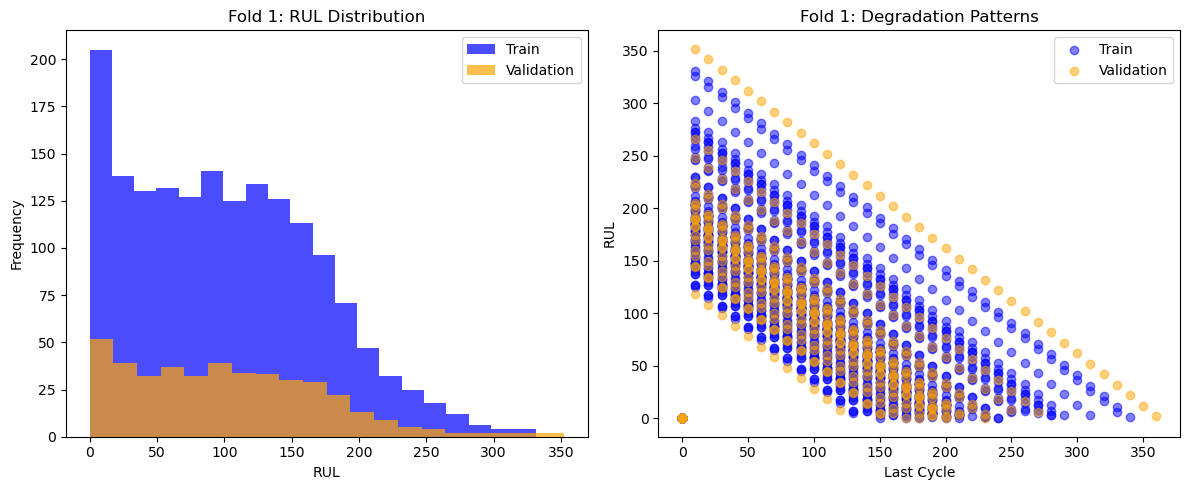

Inspecting Fold 2
  Training RUL Statistics:
count    1686.000000
mean      101.074142
std        69.567924
min         0.000000
25%        43.000000
50%        95.500000
75%       149.750000
max       352.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    420.000000
mean     101.921425
std       69.905540
min        0.000000
25%       45.000000
50%       97.000000
75%      150.000000
max      331.000000
Name: RUL, dtype: float64


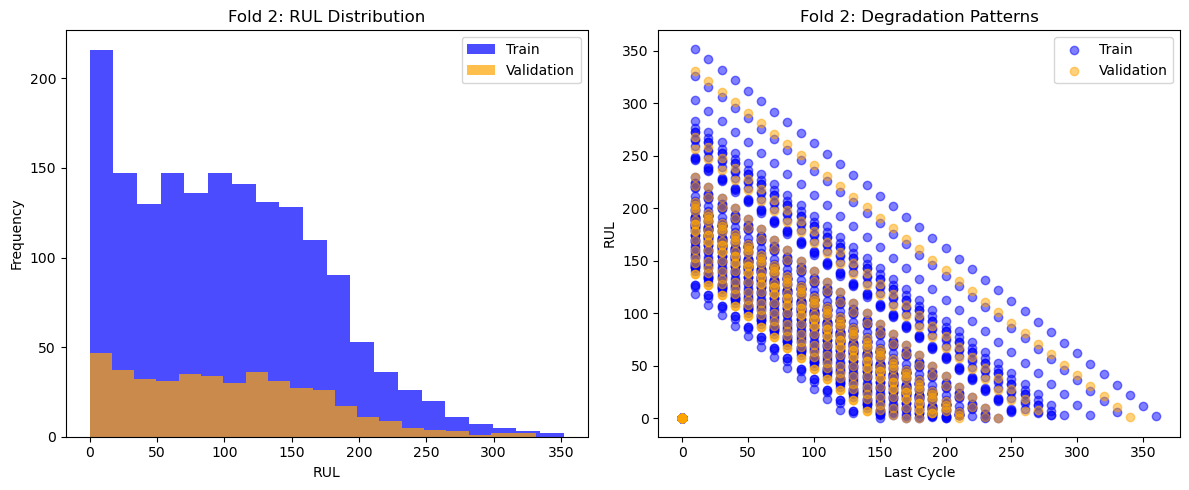

Inspecting Fold 3
  Training RUL Statistics:
count    1683.000000
mean      101.345810
std        69.565132
min         0.000000
25%        44.000000
50%        97.000000
75%       149.500000
max       352.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    423.000000
mean     100.834518
std       69.916695
min        0.000000
25%       43.000000
50%       95.000000
75%      150.000000
max      326.000000
Name: RUL, dtype: float64


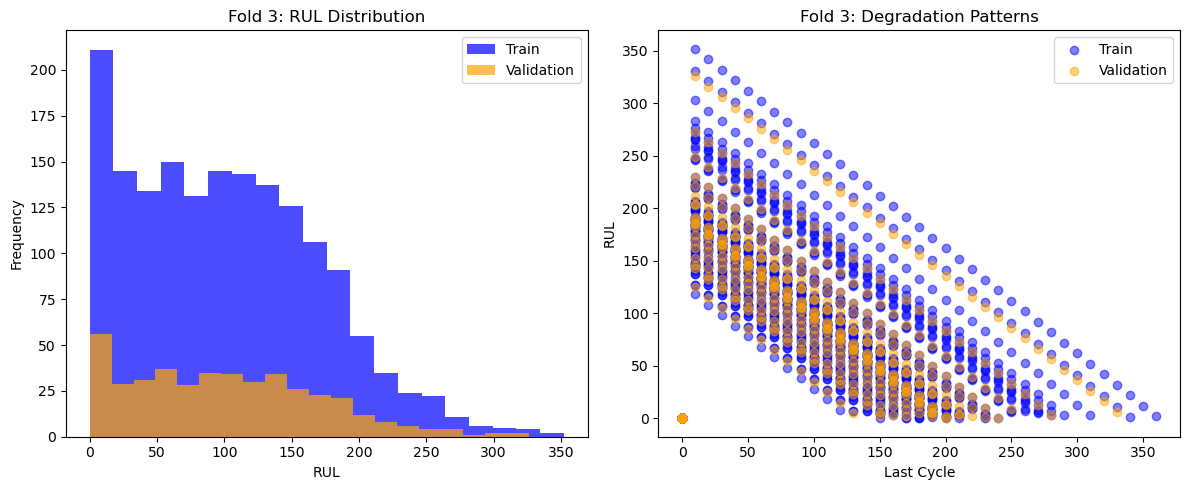

Inspecting Fold 4
  Training RUL Statistics:
count    1684.000000
mean      101.387177
std        69.828415
min         0.000000
25%        43.000000
50%        96.000000
75%       150.000000
max       352.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    422.000000
mean     100.668243
std       68.858841
min        0.000000
25%       43.250000
50%       96.000000
75%      149.000000
max      303.000000
Name: RUL, dtype: float64


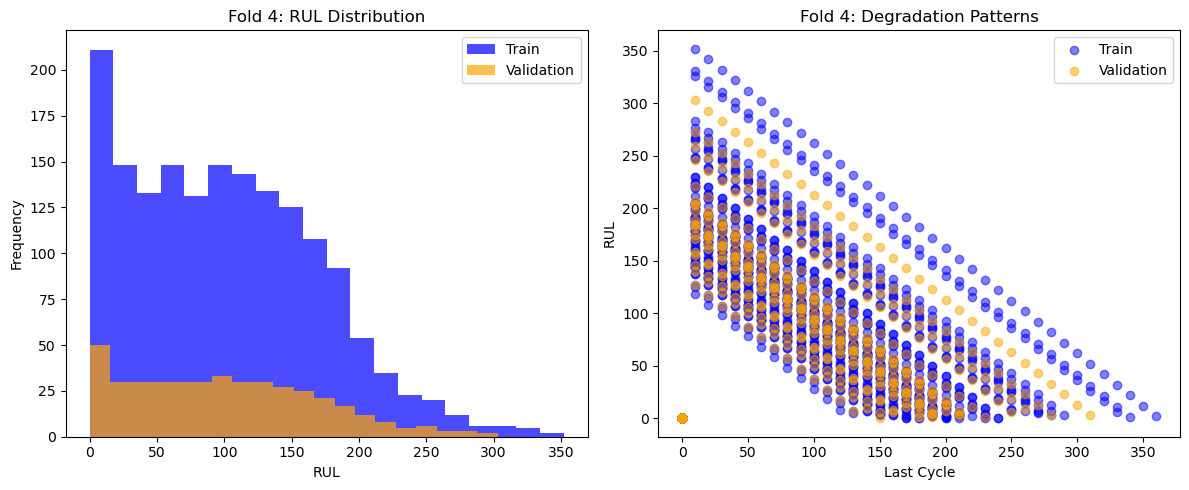

Inspecting Fold 5
  Training RUL Statistics:
count    1685.000000
mean      101.366768
std        69.995041
min         0.000000
25%        43.000000
50%        96.000000
75%       150.000000
max       352.000000
Name: RUL, dtype: float64
  Validation RUL Statistics:
count    421.000000
mean     100.748215
std       68.175606
min        0.000000
25%       44.000000
50%       97.000000
75%      148.000000
max      283.000000
Name: RUL, dtype: float64


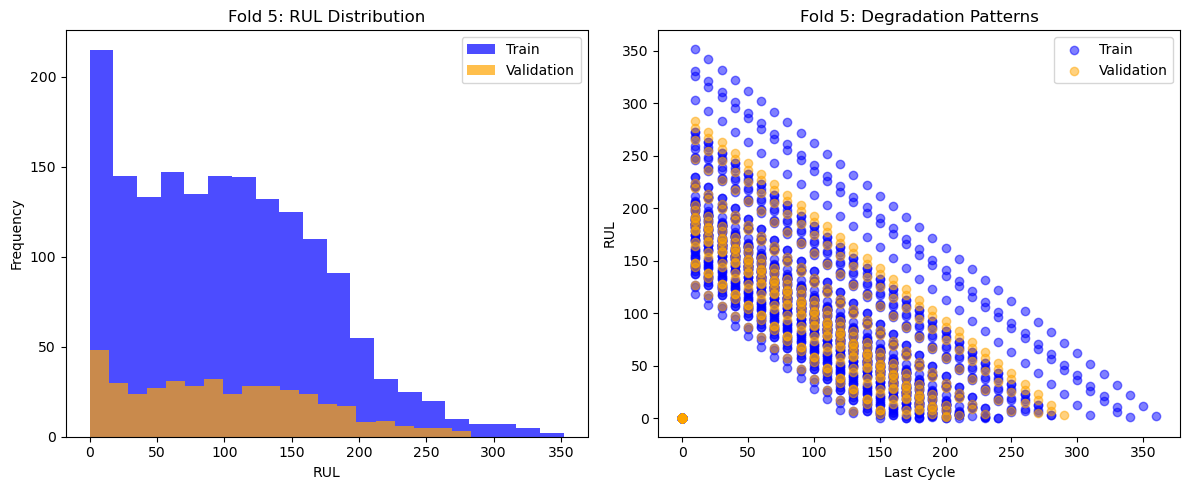

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

def inspect_fold_characteristics(fold_loaders):
    """
    Inspects and visualizes RUL distribution and degradation patterns for each fold.

    Args:
        fold_loaders (list): List of (train_loader, val_loader) tuples for k-fold cross-validation.
    """
    for fold, (train_loader, val_loader) in enumerate(fold_loaders):
        print(f"Inspecting Fold {fold + 1}")
        
        # Initialize lists to collect RUL and Cycle data
        train_ruls, train_last_cycles = [], []
        val_ruls, val_last_cycles = [], []
        
        # Collect RUL and last cycles for training
        for _, targets, _, _, cycles in train_loader:
            train_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            train_last_cycles.extend(last_cycles.tolist())
        
        # Collect RUL and last cycles for validation
        for _, targets, _, _, cycles in val_loader:
            val_ruls.extend(targets.cpu().numpy())  # RUL values (batch_size,)
            last_cycles = cycles[:, -1].cpu().numpy()  # Last cycle in each sequence (batch_size,)
            val_last_cycles.extend(last_cycles.tolist())
        
        # Convert to Pandas DataFrames for analysis
        train_df = pd.DataFrame({"RUL": train_ruls, "Last Cycle": train_last_cycles})
        val_df = pd.DataFrame({"RUL": val_ruls, "Last Cycle": val_last_cycles})
        
        # Print summary statistics
        print("  Training RUL Statistics:")
        print(train_df["RUL"].describe())
        print("  Validation RUL Statistics:")
        print(val_df["RUL"].describe())
        
        # Plot RUL distributions
        plt.figure(figsize=(12, 5))
        
        # RUL Distribution
        plt.subplot(1, 2, 1)
        plt.hist(train_df["RUL"], bins=20, alpha=0.7, label="Train", color="blue")
        plt.hist(val_df["RUL"], bins=20, alpha=0.7, label="Validation", color="orange")
        plt.xlabel("RUL")
        plt.ylabel("Frequency")
        plt.title(f"Fold {fold + 1}: RUL Distribution")
        plt.legend()

        # Degradation Patterns
        plt.subplot(1, 2, 2)
        plt.scatter(train_df["Last Cycle"], train_df["RUL"], alpha=0.5, label="Train", color="blue")
        plt.scatter(val_df["Last Cycle"], val_df["RUL"], alpha=0.5, label="Validation", color="orange")
        plt.xlabel("Last Cycle")
        plt.ylabel("RUL")
        plt.title(f"Fold {fold + 1}: Degradation Patterns")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function to inspect fold characteristics
inspect_fold_characteristics(fold_loaders)

# Conclusion
This concludes the notebook.